In [22]:
import os
import pickle
import numpy as np
import warnings
from matplotlib import pyplot as plt
import matplotlib as mpl
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
warnings.filterwarnings("ignore")
#mpl.rcParams.update({
 #   "text.usetex": True,
  #  "text.latex.preamble": r"\usepackage{bm}"  # bmパッケージを追加
#})

def graph_domain(pick_func):
    steps = 0.1
    if pick_func == "bbfunc":
        x1 = -10.0
        x2 = 10.1
    elif pick_func in ["Easom", "Ackley", "Beale", "greiwank"]:
        x1 = -5.0
        x2 = 5.1
    elif pick_func == "rastrigin":
        x1 = -5.2
        x2 = 5.3
    elif pick_func == "Himmel":
        x1 = -6.0
        x2 = 6.1
    elif pick_func == "Bukin":
        x1 = -11.0
        x2 = 11.1
    elif pick_func == "Rosenbrock":
        x1 = -3.0
        x2 = 3.1
    else: #"Goldstein", "six_hump", "three_hump", "shubert"
        x1 = -2.0
        x2 = 2.1
    return x1, x2, steps

In [23]:
def load_file(path):
    with open(path, 'rb') as file:
        data = pickle.load(file)
    return data

class DataContainer:
    def __init__(self, data):
        for key, value in data.items():
            setattr(self, key, value)

def graph_mesh(path):
    data = load_file(path)
    data_obj = DataContainer(data)
    x1, x2, step = graph_domain(data_obj.pick_func)
    x1_arange = np.round(np.arange(x1, x2, step), 1)
    x2_arange = np.round(np.arange(x1, x2, step), 1)
    x1_mesh, x2_mesh = np.meshgrid(x1_arange, x2_arange)
    x1_grid = np.round(np.arange(x1, x2, step), 2)
    x2_grid = np.round(np.arange(x1, x2, step), 2)
    grid_size = len(x1_grid)
    return x1, x2, x1_mesh, x2_mesh, x1_grid, x2_grid, grid_size

def make_nn_draft(path, counter):
    heatmap_nn_num = []
    data = load_file(path)
    data_obj = DataContainer(data)
    #print(data_obj.mlp_dic[f"{counter}"])
    nn_num = len(data_obj.mlp_dic[f"{counter}"])
    #print("NN体数", nn_num)
    x1, x2, _, _, x1_grid, x2_grid, grid_size = graph_mesh(path)
    for nn in range(nn_num):
        heatmap = np.zeros((grid_size, grid_size))
        #print("nn番目", nn)
        for i, x1 in enumerate(x1_grid):
            for j, x2 in enumerate(x2_grid):
                point = np.array([[x1, x2]])
                pred = data_obj.mlp_dic[f"{counter}"][nn].predict(point)
                heatmap[i, j] = pred
        heatmap_nn_num.append(heatmap)
    return heatmap_nn_num

def make_nn_graph(path, heatmap_nn_num):
    x1, x2, x1_mesh, x2_mesh, x1_grid, x2_grid, grid_size = graph_mesh(path)
    data = load_file(path)
    data_obj = DataContainer(data)
    nn_num = len(data_obj.mlp_dic[f"{counter}"])
    ncols = 2
    nn_num = len(data_obj.mlp_dic[f"{counter}"])
    nrows = (nn_num + ncols - 1) // ncols
    fig, axs = plt.subplots(nrows, ncols, figsize=(5, 15))
    axs = axs.flatten()
    split = int(np.round(len(x1_mesh[0])/10) + 1)
    mse = []
    for nn in range(nn_num):
        y_pred = data_obj.mlp_dic[f"{counter}"][nn].predict(data_obj.x[:counter])
        mse = mean_squared_error(data_obj.y[:counter], y_pred)
        im = axs[nn].pcolormesh(x1_mesh, x2_mesh, heatmap_nn_num[nn].T, shading='auto', cmap='viridis')
        axs[nn].set_title('NN_{:03d}th, loss='.format(nn) + str(np.round(mse, 3)), fontsize=6)
        axs[nn].set_xticks(np.linspace(x1_mesh[0][0], x1_mesh[0][-1], split))
        axs[nn].set_yticks(np.linspace(x1_mesh[0][0], x1_mesh[0][-1], split))
        #for k in range(len(data_obj.x[:counter])):  # xの点をプロット
            #axs[nn].scatter(data_obj.x[:counter][k, 0], data_obj.x[:counter][k, 1], c='w', edgecolors='k', s=40)
        fig.colorbar(im, ax=axs[nn])
    for ax in axs[nn_num:]:
        ax.axis('off')
    plt.show()

def ready_ave_std(path, heatmap_nn_num):
    heatmap_arrayed = np.array(heatmap_nn_num)
    ave_nn = np.zeros((len(heatmap_nn_num[-1]), len(heatmap_nn_num[-1]))) 
    std_nn = np.zeros((len(heatmap_nn_num[-1]), len(heatmap_nn_num[-1])))
    #print("shape=ave_nn", np.shape(ave_nn)[0])
    ave_nn = np.mean(heatmap_arrayed, axis=0)
    std_nn = np.std(heatmap_arrayed, axis=0)
    print("ave_nn min/max:", np.min(ave_nn), np.max(ave_nn))
    #print("std_nn min/max:", np.min(std_nn), np.max(std_nn))

    return ave_nn, std_nn

#def classical(heatmap_nn_num):
    

def beta_value(counter, on):
    counter += 3
    #print("fro_beta", on)
    beta = on * np.square(np.log(counter)/counter)
    return beta

def ave_std(path, heatmap_nn_num, counter, fro_beta):
    data = load_file(path)
    data_obj = DataContainer(data)
    x1, x2, x1_mesh, x2_mesh, _, _, _ = graph_mesh(path)
    ave_nn, std_nn = ready_ave_std(path, heatmap_nn_num)
    beta = beta_value(counter, fro_beta)
    ucb = ave_nn + beta*std_nn
    
    ncols = 4
    nn_num = len(data_obj.mlp_dic[f"{counter}"])
    nrows = (nn_num + ncols - 1) // ncols
    fig, axs = plt.subplots(1, 3, figsize=(28, 7))
    split = int(np.round(len(x1_mesh[0])/10) + 1)
    
    im = axs[0].pcolormesh(x1_mesh, x2_mesh, ave_nn.T, shading='auto', cmap='viridis')
    axs[0].set_title('Average')
    axs[0].set_xticks(np.linspace(x1_mesh[0][0], x1_mesh[0][-1], split))
    axs[0].set_yticks(np.linspace(x1_mesh[0][0], x1_mesh[0][-1], split))
    fig.colorbar(im, ax=axs[0])

    #2枚目
    im = axs[1].pcolormesh(x1_mesh, x2_mesh, std_nn.T, shading='auto', cmap='viridis')
    #axs[1].set_title(r'$V(\bm{x}, \Theta)$', fontsize=15)
    #axs[1].set_xlabel(r"$\bm{x}_1$", fontsize=15)
    #axs[1].set_ylabel(r"$\bm{x}_2$", fontsize=15)
    axs[1].set_xticks(np.linspace(x1_mesh[0][0], x1_mesh[0][-1], split))
    axs[1].set_yticks(np.linspace(x1_mesh[0][0], x1_mesh[0][-1], split))
    axs[1].scatter(data_obj.x[:5, 0], data_obj.x[:5, 1], c='b', edgecolors='black', s=25)
    axs[1].scatter(data_obj.x[5:30, 0], data_obj.x[5:30, 1], c='r', edgecolors='black', s=25)
    axs[1].scatter(data_obj.x[30:, 0], data_obj.x[30:, 1], c='w', edgecolors='black', s=25)
    fig.colorbar(im, ax=axs[1])

    #3枚目
    im = axs[2].pcolormesh(x1_mesh, x2_mesh, ucb.T, shading='auto', cmap='viridis')
    #if type(beta) is float or np.float64:
        #axs[2].set_title(r'$E + {:0.2f} \times V$'.format(beta), fontsize=15)
    #else:
        #axs[2].set_title(r'$E + {:02d} \times V$'.format(beta), fontsize=15)
    #axs[2].set_xlabel(r"$\bm{x}_1$", fontsize=15)
    #axs[2].set_ylabel(r"$\bm{x}_2$", fontsize=15)
    axs[2].set_xticks(np.linspace(x1_mesh[0][0], x1_mesh[0][-1], split))
    axs[2].set_yticks(np.linspace(x1_mesh[0][0], x1_mesh[0][-1], split))
    #axs[2].scatter(next_point[:, 0], next_point[:, 1], c='r', s=40)
    #axs[2].text(next_point[:, 0], next_point[:, 1], str(next_point), fontsize=10)
    fig.colorbar(im, ax=axs[2])
    
    
def y_value_steps(path):
    data = load_file(path)
    data_obj = DataContainer(data)
    plt.figure(figsize=(10, 5))
    plt.plot(data_obj.res_y)
    plt.title('y values, at steps')
    plt.show()

surrogate_2024_12_04/Himmel/beta_logarithm/seed0_True/hidden10_True/nn50/on3.0/Himmel_log_s0_h10_nn50_on3.0
ave_nn min/max: -1.501676134175297 0.7843048386103704


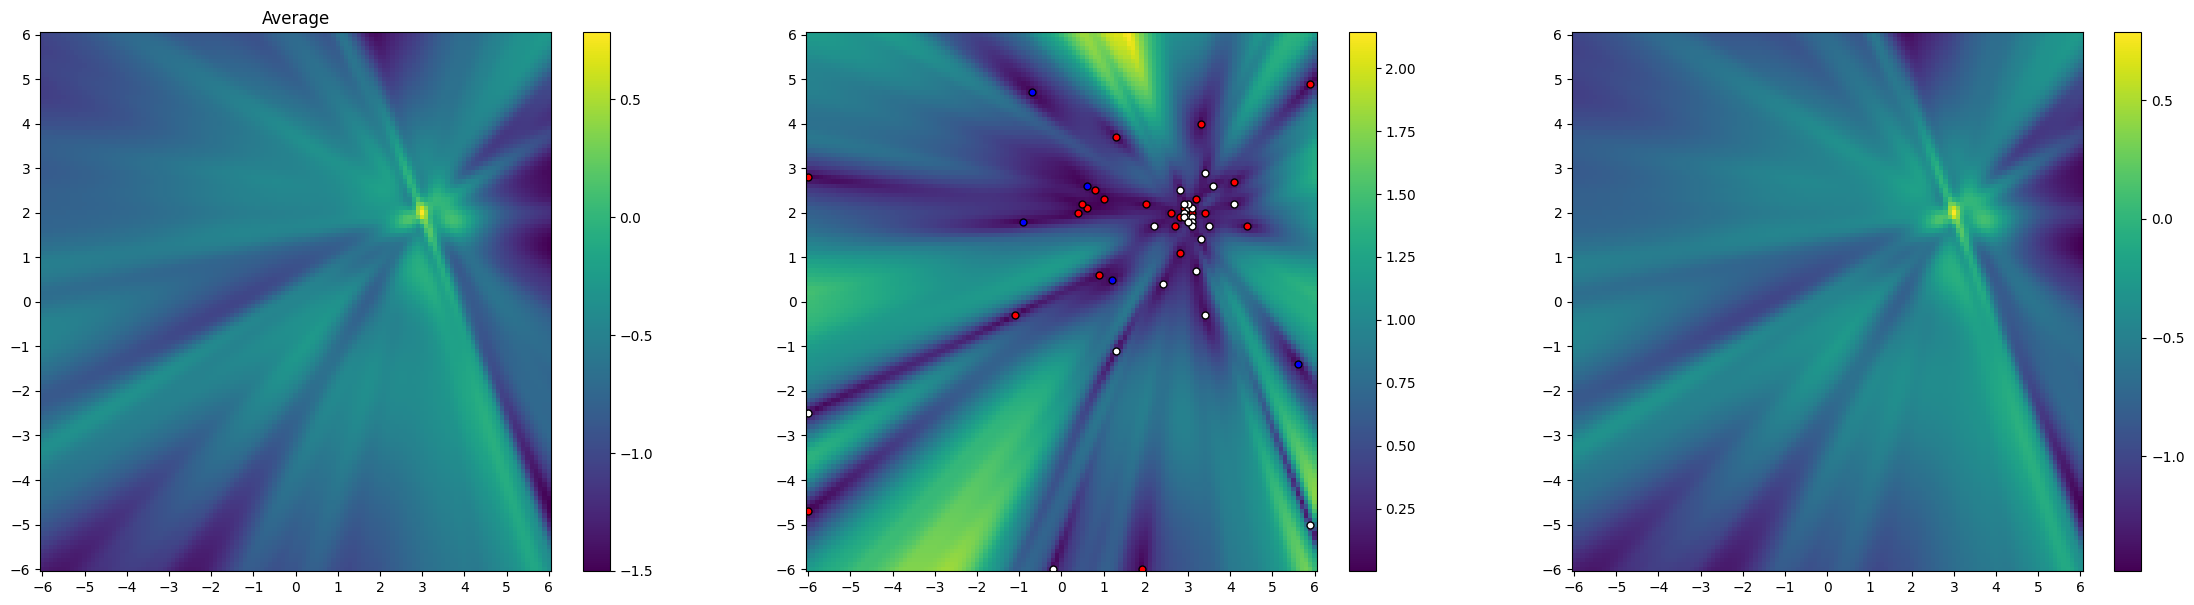

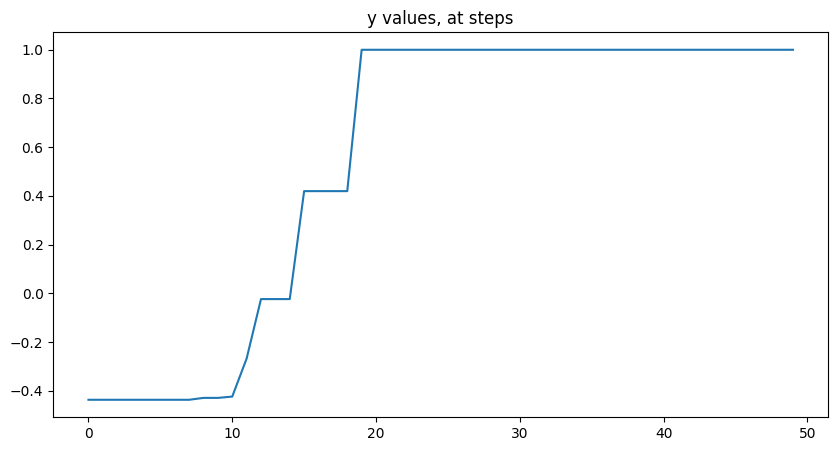

In [35]:
fro_beta = [0.5, 1.0, 2.0, 3.0]
beta = [0.0, 0.5, 1.0, 2.0, 3.0]

top_name = 'surrogate_2024_12_04'
explore = ["random", "beta_logarithm", "beta_listed"]

function = 'Himmel'
ex = explore[1]
if ex == "random":
    undead = "ran"
elif ex == "beta_logarithm":
    undead = "log"
elif ex == "beta_listed":
    undead = "list"

add_node = True
seed = 0 # 0~9
nn = 50 #10, 30, 50
h = 10 #3, 5, 10, 30
counter = 49 #count of surrogate_model
on = fro_beta[3]

path = f'{top_name}/{function}/{ex}/seed{seed}_True/hidden{h}_{add_node}/nn{nn}/on{on}/{function}_{undead}_s{seed}_h{h}_nn{nn}_on{on}'
print(path)
heatmap_nn_num = make_nn_draft(path, counter)

#make_nn_graph(path, heatmap_nn_num)
ave_std(path, heatmap_nn_num, counter, on)
y_value_steps(path)